In [1]:
import sys
import os

# Add the `src` directory to Python's module search path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Go up one level from `notebooks`
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import gtfs_kit as gk
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Any
from datetime import datetime, timedelta
from abc import ABC, abstractmethod
import time
from shapely.geometry import Point, Polygon 
import matplotlib.pyplot as plt


from transit_opt.preprocessing.prepare_gtfs import GTFSDataPreparator

# Configure logging 
import logging
logging.basicConfig(level=logging.INFO)


## Load and Prepare GTFS Data

In [3]:
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=3,  # 8 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes= 240.0,  # Maximum round-trip time in minutes
    no_service_threshold_minutes= 480.0,  # Threshold for no-service mapping
    log_level="DEBUG"  # Use "INFO" for production, "DEBUG" for development
)

# Define allowed headways
allowed_headways = [10, 15, 30, 60, 120]
# Extract all data from the GTFS feed needed for optimization 
opt_data = preparator.extract_optimization_data(allowed_headways)


2025-08-26 14:30:27,764 - transit_opt.preprocessing.prepare_gtfs - INFO - Initializing GTFSDataPreparator with 3h intervals
INFO:transit_opt.preprocessing.prepare_gtfs:Initializing GTFSDataPreparator with 3h intervals
2025-08-26 14:30:27,766 - transit_opt.preprocessing.prepare_gtfs - DEBUG - Configuration: turnaround_buffer=1.15, max_round_trip=240.0min, no_service_threshold=480.0min
DEBUG:transit_opt.preprocessing.prepare_gtfs:Configuration: turnaround_buffer=1.15, max_round_trip=240.0min, no_service_threshold=480.0min
2025-08-26 14:30:27,767 - transit_opt.preprocessing.prepare_gtfs - INFO - Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
INFO:transit_opt.preprocessing.prepare_gtfs:Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip
2025-08-26 14:30:30,481 - transit_opt.preprocessing.prepare_gtfs - DEBUG - GTFS feed loaded successfully: 187 routes, 13974 trips
DEBUG:transit_opt.preprocessing.prepare_gtfs:GTFS feed loaded successfully: 187 routes, 13974 trip

### Exploration of current service patterns

In [4]:
# =============================================================================
# DATA EXPLORATION: Understanding the Optimization Data Structure
# =============================================================================

print("=== OPTIMIZATION DATA OVERVIEW ===")
print(f"Problem Type: {opt_data['problem_type']}")
print(f"Decision Matrix Shape: {opt_data['decision_matrix_shape']}")
print(f"Variable Bounds: {opt_data['variable_bounds']}")
print(f"Number of Discrete Choices: {opt_data['n_choices']}")

print(f"\n=== ALLOWED HEADWAYS ===")
for i, headway in enumerate(opt_data['allowed_headways']):
    if headway >= 9000:
        print(f"  Index {i}: No Service ({headway})")
    else:
        print(f"  Index {i}: {headway:.0f} minutes")

print(f"\n=== TIME INTERVALS ===")
for i, (label, hours) in enumerate(zip(opt_data['intervals']['labels'], opt_data['intervals']['hours'])):
    print(f"  Interval {i}: {label} ({hours[0]:02d}:00-{hours[1]:02d}:00)")

=== OPTIMIZATION DATA OVERVIEW ===
Problem Type: discrete_headway_optimization
Decision Matrix Shape: (141, 8)
Variable Bounds: (0, 5)
Number of Discrete Choices: 6

=== ALLOWED HEADWAYS ===
  Index 0: 10 minutes
  Index 1: 15 minutes
  Index 2: 30 minutes
  Index 3: 60 minutes
  Index 4: 120 minutes
  Index 5: No Service (9999.0)

=== TIME INTERVALS ===
  Interval 0: 00-03h (00:00-03:00)
  Interval 1: 03-06h (03:00-06:00)
  Interval 2: 06-09h (06:00-09:00)
  Interval 3: 09-12h (09:00-12:00)
  Interval 4: 12-15h (12:00-15:00)
  Interval 5: 15-18h (15:00-18:00)
  Interval 6: 18-21h (18:00-21:00)
  Interval 7: 21-24h (21:00-24:00)


In [5]:
# =============================================================================
# ROUTE CHARACTERISTICS ANALYSIS
# =============================================================================

route_ids = opt_data['routes']['ids']
round_trip_times = opt_data['routes']['round_trip_times']
current_headways = opt_data['routes']['current_headways']

print("=== ROUTE CHARACTERISTICS ===")
print(f"Total Routes: {len(route_ids)}")

print(f"\n🚌 ROUND-TRIP TIME DISTRIBUTION:")
print(f"  Min: {np.min(round_trip_times):.1f} minutes")
print(f"  Mean: {np.mean(round_trip_times):.1f} minutes")
print(f"  Median: {np.median(round_trip_times):.1f} minutes")
print(f"  Max: {np.max(round_trip_times):.1f} minutes")

# Categorize routes by round-trip time
short_routes = np.sum(round_trip_times <= 60)
medium_routes = np.sum((round_trip_times > 60) & (round_trip_times <= 120))
long_routes = np.sum(round_trip_times > 120)

print(f"\n🚌 ROUTE CATEGORIES BY DURATION:")
print(f"  Short Routes (≤60min): {short_routes} ({100*short_routes/len(route_ids):.1f}%)")
print(f"  Medium Routes (60-120min): {medium_routes} ({100*medium_routes/len(route_ids):.1f}%)")
print(f"  Long Routes (>120min): {long_routes} ({100*long_routes/len(route_ids):.1f}%)")

print(f"\n📊 SERVICE COVERAGE BY INTERVAL:")
for i, label in enumerate(opt_data['intervals']['labels']):
    active_routes = np.sum(~np.isnan(current_headways[:, i]))
    coverage_pct = 100 * active_routes / len(route_ids)
    print(f"  {label}: {active_routes}/{len(route_ids)} routes active ({coverage_pct:.1f}%)")

=== ROUTE CHARACTERISTICS ===
Total Routes: 141

🚌 ROUND-TRIP TIME DISTRIBUTION:
  Min: 13.8 minutes
  Mean: 115.2 minutes
  Median: 110.4 minutes
  Max: 239.2 minutes

🚌 ROUTE CATEGORIES BY DURATION:
  Short Routes (≤60min): 20 (14.2%)
  Medium Routes (60-120min): 61 (43.3%)
  Long Routes (>120min): 60 (42.6%)

📊 SERVICE COVERAGE BY INTERVAL:
  00-03h: 9/141 routes active (6.4%)
  03-06h: 38/141 routes active (27.0%)
  06-09h: 106/141 routes active (75.2%)
  09-12h: 86/141 routes active (61.0%)
  12-15h: 94/141 routes active (66.7%)
  15-18h: 106/141 routes active (75.2%)
  18-21h: 74/141 routes active (52.5%)
  21-24h: 48/141 routes active (34.0%)


In [6]:
# =============================================================================
# CURRENT HEADWAY PATTERNS ANALYSIS
# =============================================================================

print("=== CURRENT HEADWAY PATTERNS ===")

# Overall statistics - Filter out extreme values using threshold
valid_headways = current_headways[~np.isnan(current_headways)]
# Filter out values above the no-service threshold (typically 480 minutes = 8 hours)
regular_service_headways = valid_headways[valid_headways < preparator.no_service_threshold_minutes]

if len(regular_service_headways) > 0:
    print(f"\n📈 HEADWAY STATISTICS (regular service only, <{preparator.no_service_threshold_minutes:.0f}min):")
    print(f"  Min: {np.min(regular_service_headways):.1f} minutes")
    print(f"  Mean: {np.mean(regular_service_headways):.1f} minutes")
    print(f"  Median: {np.median(regular_service_headways):.1f} minutes")
    print(f"  Max: {np.max(regular_service_headways):.1f} minutes")
    print(f"  Count: {len(regular_service_headways):,} intervals (vs {len(valid_headways):,} total)")
    
    # Headway distribution (using regular service only)
    frequent = np.sum(regular_service_headways <= 15)
    moderate = np.sum((regular_service_headways > 15) & (regular_service_headways <= 60))
    infrequent = np.sum(regular_service_headways > 60)
    
    print(f"\n📊 SERVICE FREQUENCY DISTRIBUTION (regular service):")
    print(f"  Frequent Service (≤15min): {frequent} ({100*frequent/len(regular_service_headways):.1f}%)")
    print(f"  Moderate Service (15-60min): {moderate} ({100*moderate/len(regular_service_headways):.1f}%)")
    print(f"  Infrequent Service (>60min): {infrequent} ({100*infrequent/len(regular_service_headways):.1f}%)")
    
    # Show extreme values separately
    extreme_headways = valid_headways[valid_headways >= preparator.no_service_threshold_minutes]
    if len(extreme_headways) > 0:
        print(f"\n⚠️  IRREGULAR SERVICE (≥{preparator.no_service_threshold_minutes:.0f}min): {len(extreme_headways)} intervals")
        print(f"  These represent once-daily, once-weekly, or irregular services")
        print(f"  Values: {np.unique(extreme_headways)[:5]} {'...' if len(np.unique(extreme_headways)) > 5 else ''}")

else:
    print(f"\n⚠️  No regular service found (all headways ≥{preparator.no_service_threshold_minutes:.0f}min)")

# Service patterns by time of day (also filter extreme values)
print(f"\n🕐 AVERAGE HEADWAYS BY TIME OF DAY (regular service only):")
for i, label in enumerate(opt_data['intervals']['labels']):
    interval_headways = current_headways[:, i]
    valid_interval = interval_headways[~np.isnan(interval_headways)]
    regular_interval = valid_interval[valid_interval < preparator.no_service_threshold_minutes]
    
    if len(regular_interval) > 0:
        avg_headway = np.mean(regular_interval)
        print(f"  {label}: {avg_headway:.1f} min average ({len(regular_interval)} regular routes, {len(valid_interval)-len(regular_interval)} irregular)")
    elif len(valid_interval) > 0:
        irregular_count = len(valid_interval) - len(regular_interval)
        print(f"  {label}: No regular service ({irregular_count} irregular routes)")
    else:
        print(f"  {label}: No active routes")

=== CURRENT HEADWAY PATTERNS ===

📈 HEADWAY STATISTICS (regular service only, <480min):
  Min: 1.0 minutes
  Mean: 22.2 minutes
  Median: 17.2 minutes
  Max: 125.0 minutes
  Count: 459 intervals (vs 561 total)

📊 SERVICE FREQUENCY DISTRIBUTION (regular service):
  Frequent Service (≤15min): 214 (46.6%)
  Moderate Service (15-60min): 235 (51.2%)
  Infrequent Service (>60min): 10 (2.2%)

⚠️  IRREGULAR SERVICE (≥480min): 102 intervals
  These represent once-daily, once-weekly, or irregular services
  Values: [1440.] 

🕐 AVERAGE HEADWAYS BY TIME OF DAY (regular service only):
  00-03h: 31.7 min average (6 regular routes, 3 irregular)
  03-06h: 20.3 min average (27 regular routes, 11 irregular)
  06-09h: 19.5 min average (73 regular routes, 33 irregular)
  09-12h: 25.3 min average (83 regular routes, 3 irregular)
  12-15h: 23.9 min average (85 regular routes, 9 irregular)
  15-18h: 22.0 min average (84 regular routes, 22 irregular)
  18-21h: 21.2 min average (66 regular routes, 8 irregular)

In [7]:
# =============================================================================
# INITIAL SOLUTION ANALYSIS
# =============================================================================

initial_solution = opt_data['initial_solution']
allowed_headways = opt_data['allowed_headways']

print("=== INITIAL SOLUTION MAPPING ===")
print("How current GTFS headways map to discrete choices:\n")

# Count frequency of each choice in initial solution
choice_counts = {}
for choice_idx in range(opt_data['n_choices']):
    count = np.sum(initial_solution == choice_idx)
    choice_counts[choice_idx] = count

# Display mapping statistics
total_cells = initial_solution.size
for choice_idx in sorted(choice_counts.keys()):
    count = choice_counts[choice_idx]
    percentage = 100 * count / total_cells
    headway_val = allowed_headways[choice_idx]
    
    if headway_val >= 9000:
        print(f"  Choice {choice_idx} (No Service): {count:,} cells ({percentage:.1f}%)")
    else:
        print(f"  Choice {choice_idx} ({headway_val:.0f}min): {count:,} cells ({percentage:.1f}%)")

service_cells = total_cells - choice_counts.get(opt_data['no_service_index'], 0)
print(f"\nOverall: {service_cells:,}/{total_cells:,} cells with active service ({100*service_cells/total_cells:.1f}%)")

=== INITIAL SOLUTION MAPPING ===
How current GTFS headways map to discrete choices:

  Choice 0 (10min): 183 cells (16.2%)
  Choice 1 (15min): 88 cells (7.8%)
  Choice 2 (30min): 134 cells (11.9%)
  Choice 3 (60min): 52 cells (4.6%)
  Choice 4 (120min): 2 cells (0.2%)
  Choice 5 (No Service): 669 cells (59.3%)

Overall: 459/1,128 cells with active service (40.7%)


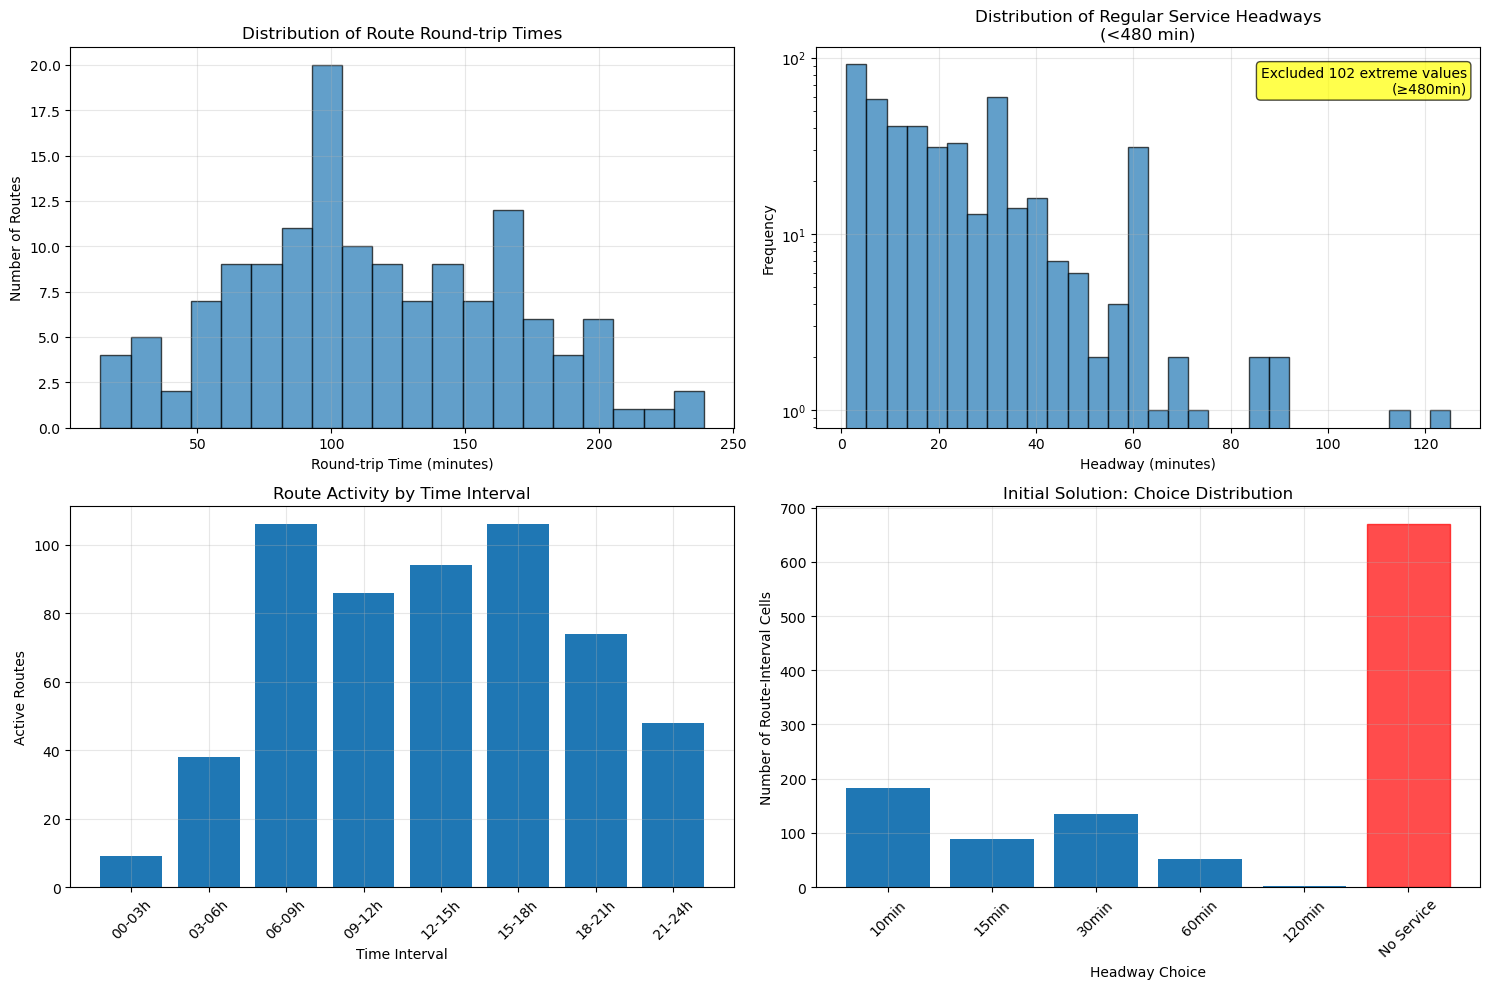


Visualization shows:
  • Route complexity (round-trip times)
  • Regular service frequency patterns (extreme values filtered)
  • When routes are most/least active
  • How existing service maps to optimization choices


In [ ]:
# =============================================================================
# VISUALIZE CURRENT SERVICE PATTERNS
# =============================================================================

# Create a comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Round-trip time distribution (unchanged)
axes[0,0].hist(round_trip_times, bins=20, alpha=0.7, edgecolor='black')
axes[0,0].set_xlabel('Round-trip Time (minutes)')
axes[0,0].set_ylabel('Number of Routes')
axes[0,0].set_title('Distribution of Route Round-trip Times')
axes[0,0].grid(True, alpha=0.3)

# 2. Valid headways distribution - filter extreme values
valid_headways = current_headways[~np.isnan(current_headways)]
regular_service_headways = valid_headways[valid_headways < preparator.no_service_threshold_minutes]

if len(regular_service_headways) > 0:
    axes[0,1].hist(regular_service_headways, bins=30, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Headway (minutes)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title(f'Distribution of Regular Service Headways\n(<{preparator.no_service_threshold_minutes:.0f} min)')
    axes[0,1].set_yscale('log')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add text showing filtered count
    extreme_count = len(valid_headways) - len(regular_service_headways)
    axes[0,1].text(0.98, 0.95, f'Excluded {extreme_count} extreme values\n(≥{preparator.no_service_threshold_minutes:.0f}min)', 
                   transform=axes[0,1].transAxes, ha='right', va='top',
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
else:
    axes[0,1].text(0.5, 0.5, 'No Regular Service\nFound', 
                   ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Distribution of Regular Service Headways')

# 3. Service coverage by interval (unchanged)
interval_labels = opt_data['intervals']['labels']
active_counts = [np.sum(~np.isnan(current_headways[:, i])) for i in range(opt_data['n_intervals'])]

axes[1,0].bar(range(len(active_counts)), active_counts)
axes[1,0].set_xlabel('Time Interval')
axes[1,0].set_ylabel('Active Routes')
axes[1,0].set_title('Route Activity by Time Interval')
axes[1,0].set_xticks(range(len(interval_labels)))
axes[1,0].set_xticklabels(interval_labels, rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Initial solution choice distribution (unchanged)
choice_labels = [f"{h:.0f}min" if h < 9000 else "No Service" for h in allowed_headways]
choice_counts_list = [choice_counts.get(i, 0) for i in range(opt_data['n_choices'])]

bars = axes[1,1].bar(range(len(choice_counts_list)), choice_counts_list)
axes[1,1].set_xlabel('Headway Choice')
axes[1,1].set_ylabel('Number of Route-Interval Cells')
axes[1,1].set_title('Initial Solution: Choice Distribution')
axes[1,1].set_xticks(range(len(choice_labels)))
axes[1,1].set_xticklabels(choice_labels, rotation=45)

# Highlight no-service bar
bars[opt_data['no_service_index']].set_color('red')
bars[opt_data['no_service_index']].set_alpha(0.7)

axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nVisualization shows:")
print(f"  • Route complexity (round-trip times)")
print(f"  • Regular service frequency patterns (extreme values filtered)")
print(f"  • When routes are most/least active")
print(f"  • How existing service maps to optimization choices")

### Fleet analysis

Check the `fleet_analysis` output to see the fleet requirements of the existing service

In [9]:
# Comprehensive fleet analysis display
fleet_analysis = opt_data['constraints']['fleet_analysis']

print("=== FLEET ANALYSIS SUMMARY ===")
print(f"📊 Total Routes: {opt_data['n_routes']}")
print(f"📊 Active Routes: {fleet_analysis['fleet_stats']['routes_with_service']}")
print(f"📊 Time Intervals: {opt_data['n_intervals']} ({opt_data['intervals']['duration_minutes']//60}h each)")

print(f"\n🚗 FLEET REQUIREMENTS:")
print(f"Peak Fleet Needed: {fleet_analysis['total_current_fleet_peak']} vehicles")
print(f"Fleet by Interval: {fleet_analysis['current_fleet_by_interval'].tolist()}")
print(f"Peak Interval: {fleet_analysis['fleet_stats']['peak_interval']} ({opt_data['intervals']['labels'][fleet_analysis['fleet_stats']['peak_interval']]})")
print(f"Off-Peak Minimum: {fleet_analysis['fleet_stats']['off_peak_fleet']} vehicles")

print(f"\n📈 EFFICIENCY:")
efficiency_gain = fleet_analysis['fleet_stats']['fleet_efficiency_gain']
if efficiency_gain > 0:
    print(f"Efficiency Gain: {efficiency_gain} vehicles saved ({efficiency_gain/(fleet_analysis['total_current_fleet_peak']+efficiency_gain)*100:.1f}% reduction)")
else:
    print(f"No efficiency gain (all routes peak simultaneously)")

print(f"\n🔧 ROUTE DISTRIBUTION:")
dist = fleet_analysis['fleet_stats']['fleet_distribution']
print(f"Small Routes (1-5 vehicles): {dist['small_routes']}")
print(f"Medium Routes (6-15 vehicles): {dist['medium_routes']}")
print(f"Large Routes (>15 vehicles): {dist['large_routes']}")

print(f"\n⚙️ CONFIGURATION:")
print(f"Operational Buffer: {fleet_analysis['operational_buffer']} ({(fleet_analysis['operational_buffer']-1)*100:.0f}% extra time)")

=== FLEET ANALYSIS SUMMARY ===
📊 Total Routes: 141
📊 Active Routes: 141
📊 Time Intervals: 8 (3h each)

🚗 FLEET REQUIREMENTS:
Peak Fleet Needed: 1653 vehicles
Fleet by Interval: [29, 434, 1351, 1469, 1582, 1653, 1071, 670]
Peak Interval: 5 (15-18h)
Off-Peak Minimum: 29 vehicles

📈 EFFICIENCY:
Efficiency Gain: 418 vehicles saved (20.2% reduction)

🔧 ROUTE DISTRIBUTION:
Small Routes (1-5 vehicles): 72
Medium Routes (6-15 vehicles): 33
Large Routes (>15 vehicles): 36

⚙️ CONFIGURATION:
Operational Buffer: 1.15 (15% extra time)


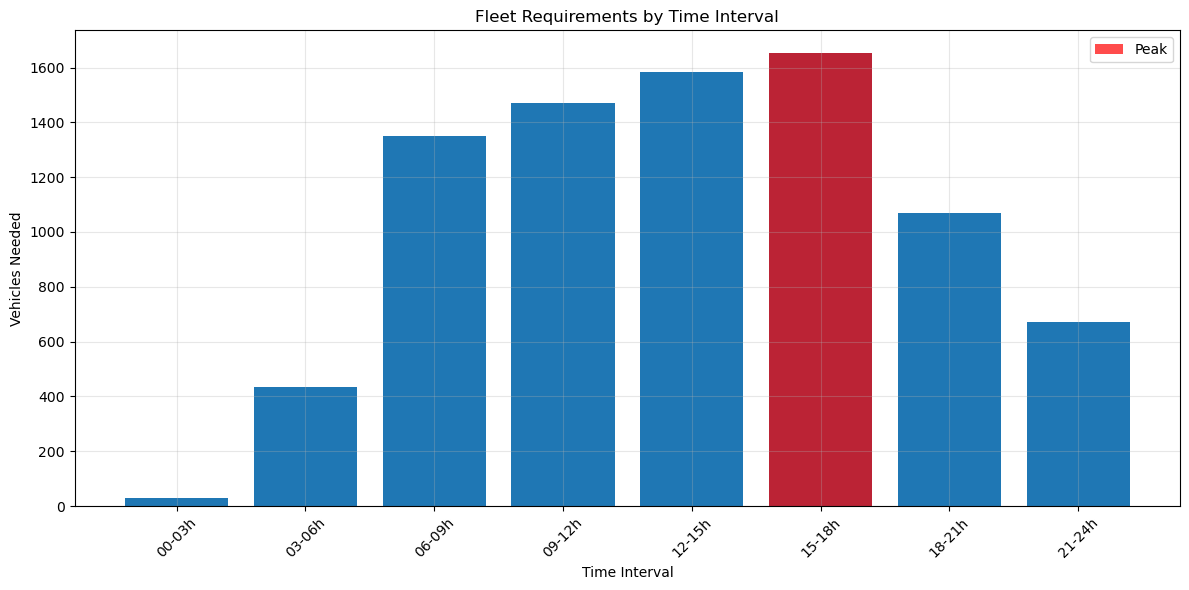

Peak occurs during 15-18h with 1653 vehicles needed


In [10]:
# Plot fleet requirements by interval
import matplotlib.pyplot as plt

fleet_by_interval = fleet_analysis['current_fleet_by_interval']
interval_labels = opt_data['intervals']['labels']

plt.figure(figsize=(12, 6))
plt.bar(range(len(fleet_by_interval)), fleet_by_interval)
plt.xlabel('Time Interval')
plt.ylabel('Vehicles Needed')
plt.title('Fleet Requirements by Time Interval')
plt.xticks(range(len(interval_labels)), interval_labels, rotation=45)
plt.grid(True, alpha=0.3)

# Highlight peak interval
peak_idx = fleet_analysis['fleet_stats']['peak_interval']
plt.bar(peak_idx, fleet_by_interval[peak_idx], color='red', alpha=0.7, label='Peak')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Peak occurs during {interval_labels[peak_idx]} with {fleet_by_interval[peak_idx]} vehicles needed")

In [13]:
# =============================================================================
# FIXED GTFS RECONSTRUCTOR
# =============================================================================

class SimplifiedGTFSReconstructor:
    """
    UPDATED: Reconstructor compatible with improved optimization data structure.
    """
    
    def __init__(self, optimization_data: Dict[str, Any], optimization_result: Dict[str, Any]):
        self.optimization_data = optimization_data
        self.optimization_result = optimization_result
        
        # UPDATED: Access GTFS feed from new structure
        self.feed = optimization_data['reconstruction']['gtfs_feed']
        
        # Decode solution
        self.optimized_headways = self._decode_headway_solution()
    
    def _decode_headway_solution(self) -> np.ndarray:
        """Convert optimization solution indices to actual headway values."""
        solution_indices = self.optimization_result['headway_solution']
        allowed_headways = self.optimization_data['allowed_headways']
        no_service_index = self.optimization_data['no_service_index']
        
        n_routes, n_intervals = solution_indices.shape
        headways = np.full((n_routes, n_intervals), np.nan)
        
        for i in range(n_routes):
            for j in range(n_intervals):
                choice_idx = solution_indices[i, j]
                headway_value = allowed_headways[choice_idx]
                
                if choice_idx == no_service_index or headway_value >= 9000:
                    headways[i, j] = np.nan  # No service
                else:
                    headways[i, j] = headway_value
        
        return headways
    
    def reconstruct_gtfs(self, use_frequencies: bool = False) -> Any:
        """Reconstruct GTFS with proper stop_times.txt."""
        print("=== RECONSTRUCTING GTFS WITH OPTIMIZED HEADWAYS ===")
        
        # Start with copy of original feed
        new_feed = self.feed.copy()
        
        # Generate new stop_times and trips
        new_stop_times, new_trips = self._generate_stop_times_and_trips()
        
        # Update feed
        new_feed.stop_times = new_stop_times
        new_feed.trips = new_trips
        
        # Handle frequencies (optional)
        if use_frequencies and len(new_trips) > 0:
            frequencies_df = self._create_frequencies_table(new_trips)
            if len(frequencies_df) > 0:
                new_feed.frequencies = frequencies_df
                print(f"   📊 Added {len(frequencies_df):,} frequency entries")
            else:
                new_feed.frequencies = None
                print(f"   ⚠️  No frequencies generated - skipping frequencies.txt")
        else:
            new_feed.frequencies = None
            print(f"   📊 Frequencies.txt disabled - using stop_times.txt only")
        
        print(f"✅ Reconstructed GTFS with stop_times.txt:")
        print(f"   📊 {len(new_trips):,} trips")
        print(f"   📊 {len(new_stop_times):,} stop times")
        
        return new_feed
    
    def _generate_stop_times_and_trips(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Generate both stop_times and trips tables with proper relationships."""
        new_stop_times_list = []
        new_trips_list = []
        trip_id_counter = 1
        
        # UPDATED: Use new data structure
        route_ids = self.optimization_data['routes']['ids']
        n_intervals = self.optimization_data['n_intervals']
        interval_hours = self.optimization_data['intervals']['duration_minutes'] // 60
        
        print(f"   🔄 Generating trips and stop_times for {len(route_ids)} routes")
        
        for route_idx, service_id in enumerate(route_ids):
            # Get original trips for this service
            original_trips = self.feed.trips[self.feed.trips['service_id'] == service_id]
            
            if len(original_trips) == 0:
                continue
            
            # Use first trip as template
            template_trip = original_trips.iloc[0]
            template_trip_id = template_trip['trip_id']
            
            # Get template stop_times
            template_stops = self.feed.stop_times[
                self.feed.stop_times['trip_id'] == template_trip_id
            ].sort_values('stop_sequence').copy()
            
            if len(template_stops) == 0:
                continue
            
            # Convert template times to seconds for calculations
            template_stops['departure_seconds'] = template_stops['departure_time'].apply(
                self._safe_timestr_to_seconds
            )
            template_stops['arrival_seconds'] = template_stops['arrival_time'].apply(
                self._safe_timestr_to_seconds
            )
            
            # Generate trips for each interval with service
            route_trips_generated = 0
            for interval_idx in range(n_intervals):
                headway = self.optimized_headways[route_idx, interval_idx]
                
                # Skip intervals with no service
                if np.isnan(headway):
                    continue
                
                # UPDATED: Use interval hours from data structure
                start_hour, end_hour = self.optimization_data['intervals']['hours'][interval_idx]
                interval_duration_minutes = end_hour * 60 - start_hour * 60
                
                # Calculate number of trips needed in this interval
                n_trips = max(1, int(interval_duration_minutes / headway))
                
                # Generate trips spaced by optimized headway
                for trip_num in range(n_trips):
                    # Calculate start time for this trip
                    trip_start_minutes = start_hour * 60 + (trip_num * headway)
                    
                    # Don't exceed interval boundary
                    if trip_start_minutes >= end_hour * 60:
                        break
                    
                    # Create new trip with unique ID
                    new_trip_id = f"opt_{service_id}_{interval_idx}_{trip_num}"
                    new_trip = template_trip.copy()
                    new_trip['trip_id'] = new_trip_id
                    
                    # Clear any block_id to avoid conflicts
                    if 'block_id' in new_trip:
                        new_trip['block_id'] = f"block_{trip_id_counter}"
                    
                    new_trips_list.append(new_trip)
                    
                    # Generate stop_times for this trip
                    trip_stop_times = self._create_trip_stop_times(
                        template_stops, new_trip_id, trip_start_minutes
                    )
                    
                    if trip_stop_times is not None:
                        new_stop_times_list.append(trip_stop_times)
                        route_trips_generated += 1
                    
                    trip_id_counter += 1
            
            if route_trips_generated > 0 and route_idx < 5:  # Log first few routes
                print(f"   📍 Route {route_idx} ({service_id}): Generated {route_trips_generated} trips")
        
        # Combine all data
        if new_trips_list and new_stop_times_list:
            new_trips = pd.DataFrame(new_trips_list).reset_index(drop=True)
            new_stop_times = pd.concat(new_stop_times_list, ignore_index=True)
            
            print(f"   ✅ Generated {len(new_trips):,} trips with {len(new_stop_times):,} stop times")
        else:
            # Create empty but valid DataFrames
            new_trips = self.feed.trips.iloc[0:0].copy()
            new_stop_times = self.feed.stop_times.iloc[0:0].copy()
            print(f"   ⚠️  No trips generated - all routes mapped to no service")
        
        return new_stop_times, new_trips
    
    def _create_trip_stop_times(self, template_stops: pd.DataFrame, 
                              new_trip_id: str, trip_start_minutes: float) -> Optional[pd.DataFrame]:
        """Create stop_times for a single trip based on template."""
        try:
            # Calculate time offset
            template_start_seconds = template_stops.iloc[0]['departure_seconds']
            if pd.isna(template_start_seconds):
                return None
            
            trip_start_seconds = trip_start_minutes * 60
            time_offset = trip_start_seconds - template_start_seconds
            
            # Create new stop_times
            new_stop_times = template_stops.copy()
            new_stop_times['trip_id'] = new_trip_id
            
            # Adjust all times
            new_stop_times['departure_seconds'] = template_stops['departure_seconds'] + time_offset
            new_stop_times['arrival_seconds'] = template_stops['arrival_seconds'] + time_offset
            
            # Convert back to GTFS time strings
            new_stop_times['departure_time'] = new_stop_times['departure_seconds'].apply(
                self._seconds_to_timestr
            )
            new_stop_times['arrival_time'] = new_stop_times['arrival_seconds'].apply(
                self._seconds_to_timestr
            )
            
            # Remove helper columns
            new_stop_times = new_stop_times.drop(['departure_seconds', 'arrival_seconds'], 
                                               axis=1, errors='ignore')
            
            return new_stop_times
            
        except Exception as e:
            print(f"   ⚠️  Failed to create stop_times for trip {new_trip_id}: {e}")
            return None
    
    def _create_frequencies_table(self, trips_df: pd.DataFrame) -> pd.DataFrame:
        """Create frequencies.txt that uses ACTUAL trip IDs from the new trips."""
        frequencies_list = []
        n_intervals = self.optimization_data['n_intervals']
        route_ids = self.optimization_data['routes']['ids']
        
        for route_idx, service_id in enumerate(route_ids):
            # Get trips that were actually generated for this service
            service_trips = trips_df[trips_df['service_id'] == service_id]
            
            if len(service_trips) == 0:
                continue
            
            # Create frequency entries for each interval that has service
            for interval_idx in range(n_intervals):
                headway = self.optimized_headways[route_idx, interval_idx]
                
                if np.isnan(headway):
                    continue
                
                # Find a trip that was actually generated for this interval
                interval_trips = service_trips[
                    service_trips['trip_id'].str.contains(f'_{interval_idx}_', na=False)
                ]
                
                if len(interval_trips) == 0:
                    continue
                
                # Use the first trip from this interval as the frequency template
                template_trip_id = interval_trips.iloc[0]['trip_id']
                
                # UPDATED: Get interval hours from data structure
                start_hour, end_hour = self.optimization_data['intervals']['hours'][interval_idx]
                
                frequency_entry = {
                    'trip_id': template_trip_id,
                    'start_time': f"{start_hour:02d}:00:00",
                    'end_time': f"{end_hour:02d}:00:00",
                    'headway_secs': int(headway * 60),
                    'exact_times': 0
                }
                
                frequencies_list.append(frequency_entry)
        
        return pd.DataFrame(frequencies_list)
    
    # Helper methods remain the same
    def _safe_timestr_to_seconds(self, time_value: Any) -> float:
        """Safely convert GTFS time strings to seconds."""
        try:
            if pd.isna(time_value):
                return np.nan
            if isinstance(time_value, str):
                return gk.helpers.timestr_to_seconds(time_value)
            else:
                return float(time_value)
        except Exception:
            return np.nan
    
    def _seconds_to_timestr(self, seconds: float) -> str:
        """Convert seconds to GTFS time string format."""
        if pd.isna(seconds):
            return "00:00:00"
        
        # Handle times > 24 hours (GTFS allows this)
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        
        return f"{hours:02d}:{minutes:02d}:{secs:02d}"

In [14]:

# =============================================================================
# COMPLETE WORKFLOW: DATA PREPARATION → OPTIMIZATION → RECONSTRUCTION
# =============================================================================

# 1. PREPARE OPTIMIZATION DATA
print("=== STEP 1: PREPARING OPTIMIZATION DATA ===")
preparator = GTFSDataPreparator(
    gtfs_path='../data/external/study_area_gtfs_bus.zip',
    interval_hours=3,  # 8 periods per day
    date=None,  # Use full GTFS feed
    turnaround_buffer=1.15,  # 15% buffer
    max_round_trip_minutes= 240.0  # Maximum round-trip time in minutes
)

# Define allowed headway values for discrete optimization
allowed_headways = [5, 10, 15, 20, 30, 45, 60, 90, 120]  # minutes

# Extract optimization data
optimization_data = preparator.extract_optimization_data(allowed_headways)

# 2. SIMULATE OPTIMIZATION RESULT (since you don't have the actual optimizer yet)
print("\n=== STEP 2: SIMULATING OPTIMIZATION RESULT ===")
# For now, use initial solution as the "optimized" result
simulated_result = {
    'headway_solution': optimization_data['initial_solution'],
    'objective_value': 1000.0,  # Placeholder
    'solve_time': 5.0,  # Placeholder
    'status': 'optimal'
}

print(f"✅ Using initial solution as optimization result")
print(f"   📊 Solution shape: {simulated_result['headway_solution'].shape}")

# 3. RECONSTRUCT GTFS WITH OPTIMIZED HEADWAYS
print("\n=== STEP 3: RECONSTRUCTING GTFS ===")
reconstructor = SimplifiedGTFSReconstructor(optimization_data, simulated_result)

# Generate GTFS with stop_times.txt (required for all simulations)
new_gtfs_feed = reconstructor.reconstruct_gtfs(use_frequencies=False)


# 4. SAVE THE COMPLETE GTFS FEED
print("\n=== STEP 4: SAVING OPTIMIZED GTFS ===")
if len(new_gtfs_feed.trips) > 0:
    output_path = '../data/processed/optimized_gtfs.zip'
    
    # Ensure output directory exists
    import os
    os.makedirs('../data/processed', exist_ok=True)
    
    # Use gtfs-kit's to_file() method - it handles ZIP automatically
    new_gtfs_feed.to_file(output_path)
    print(f"✅ Complete GTFS with stop_times.txt saved to: {output_path}")
    
else:
    print("⚠️  No trips generated - check optimization solution")

print("\n=== WORKFLOW COMPLETE ===")

=== STEP 1: PREPARING OPTIMIZATION DATA ===
⏱️  Loading GTFS feed from ../data/external/study_area_gtfs_bus.zip...
📅 Using full GTFS feed (all service periods)
✅ GTFS loaded and cached in 4.85 seconds
   📊 13,974 trips, 703,721 stop times
⏱️  Extracting route essentials with 3-hour intervals...
   ⚠️  Filtered out route 4075: 317.4 min round-trip (>240.0 min)
   ⚠️  Filtered out route 4122: 366.8 min round-trip (>240.0 min)
   ⚠️  Filtered out route 3985: 409.4 min round-trip (>240.0 min)
   ⚠️  Filtered out route 5496: 416.3 min round-trip (>240.0 min)
   ⚠️  Filtered out route 3986: 396.7 min round-trip (>240.0 min)
   ⚠️  Filtered out route 6790: 396.7 min round-trip (>240.0 min)
   ⚠️  Filtered out route 3228: 258.8 min round-trip (>240.0 min)
   ⚠️  Filtered out route 41: 609.5 min round-trip (>240.0 min)
   ⚠️  Filtered out route 42: 885.5 min round-trip (>240.0 min)
   ⚠️  Filtered out route 43: 575.0 min round-trip (>240.0 min)
   ⚠️  Filtered out route 44: 1023.5 min round-tri

In [15]:
simulated_result

{'headway_solution': array([[8, 2, 4, ..., 9, 1, 2],
        [8, 0, 4, ..., 8, 5, 4],
        [9, 9, 2, ..., 1, 4, 9],
        ...,
        [9, 9, 3, ..., 4, 9, 9],
        [9, 9, 9, ..., 8, 9, 9],
        [9, 9, 9, ..., 9, 9, 9]]),
 'objective_value': 1000.0,
 'solve_time': 5.0,
 'status': 'optimal'}

In [16]:
# print the optimisation_data initial_solution dictionary

optimization_data['initial_solution']  # Display the initial solution for debugging


array([[8, 2, 4, ..., 9, 1, 2],
       [8, 0, 4, ..., 8, 5, 4],
       [9, 9, 2, ..., 1, 4, 9],
       ...,
       [9, 9, 3, ..., 4, 9, 9],
       [9, 9, 9, ..., 8, 9, 9],
       [9, 9, 9, ..., 9, 9, 9]])

In [17]:
new_gtfs_feed.stop_times.head(50)  # Display the first few trips in the reconstructed GTFS feed

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_direction_name
0,opt_1221_0_0,00:00:00,00:00:00,450030232,0,<NA>,0,1,NaN,1,<NA>
1,opt_1221_0_0,00:04:00,00:04:00,450010686,1,<NA>,0,0,NaN,0,<NA>
2,opt_1221_0_0,00:05:00,00:05:00,450032353,2,<NA>,0,0,NaN,1,<NA>
3,opt_1221_0_0,00:05:46,00:05:46,450032368,3,<NA>,0,0,NaN,0,<NA>
4,opt_1221_0_0,00:07:13,00:07:13,450010695,4,<NA>,0,0,NaN,0,<NA>
5,opt_1221_0_0,00:08:48,00:08:48,450011762,5,<NA>,0,0,NaN,0,<NA>
6,opt_1221_0_0,00:09:39,00:09:39,450011761,6,<NA>,0,0,NaN,0,<NA>
7,opt_1221_0_0,00:10:46,00:10:46,450011770,7,<NA>,0,0,NaN,0,<NA>
8,opt_1221_0_0,00:11:34,00:11:34,450010923,8,<NA>,0,0,NaN,0,<NA>
9,opt_1221_0_0,00:12:36,00:12:36,450011556,9,<NA>,0,0,NaN,0,<NA>


In [18]:
# Add this new cell to your notebook
import numpy as np
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.variable import Real, Integer
import matplotlib.pyplot as plt

class SpatialEquityProblem(ElementwiseProblem):
    """
    PyMOO problem definition for spatial equity optimization.
    """
    
    def __init__(self, optimization_data, zone_system, min_fleet_factor=0.8):
        self.opt_data = optimization_data
        self.zone_system = zone_system
        self.min_fleet_factor = min_fleet_factor
        
        # Problem dimensions
        self.n_routes = optimization_data['n_routes']
        self.n_intervals = optimization_data['n_intervals'] 
        self.n_choices = optimization_data['n_choices']
        self.n_vars = self.n_routes * self.n_intervals
        
        # Calculate fleet constraints
        self.baseline_vehicles = self._calculate_baseline_fleet()
        self.min_required_vehicles = int(self.baseline_vehicles * min_fleet_factor)
        
        print(f"🚗 Fleet constraints:")
        print(f"   📊 Current fleet size: {self.baseline_vehicles} vehicles")
        print(f"   📊 Minimum required: {self.min_required_vehicles} vehicles ({min_fleet_factor:.1%})")
        
        # Define problem: discrete variables (0 to n_choices-1)
        super().__init__(
            n_var=self.n_vars,
            n_obj=1,  # Single objective: minimize variance
            n_ieq_constr=2,  # 2 inequality constraints
            vars={
                f'x{i}': Integer(bounds=(0, self.n_choices-1)) 
                for i in range(self.n_vars)
            }
        )
    
    def _calculate_baseline_fleet(self):
        """Calculate current fleet size."""
        initial_solution = self.opt_data['initial_solution']
        vehicles_per_zone = self.zone_system.calculate_vehicles_per_zone(
            initial_solution, self.opt_data
        )
        return int(np.sum(vehicles_per_zone))
    
    def _evaluate(self, x, out, *args, **kwargs):
        """
        Evaluate single solution.
        
        Args:
            x: Decision variables (flattened array of discrete choices)
        """
        # Convert to solution matrix
        solution_matrix = x.reshape(self.n_routes, self.n_intervals)
        
        # Calculate vehicles per zone
        vehicles_per_zone = self.zone_system.calculate_vehicles_per_zone(
            solution_matrix, self.opt_data
        )
        
        # Primary objective: minimize variance in vehicles per zone
        if len(vehicles_per_zone) > 1 and np.sum(vehicles_per_zone) > 0:
            objective = np.var(vehicles_per_zone)
        else:
            objective = 0.0
        
        # Constraint 1: Minimum fleet size
        total_vehicles = np.sum(vehicles_per_zone)
        fleet_constraint = self.min_required_vehicles - total_vehicles  # <= 0
        
        # Constraint 2: Maximum service reduction (no more than 60% no-service)
        no_service_count = np.sum(solution_matrix == (self.n_choices - 1))
        no_service_ratio = no_service_count / solution_matrix.size
        service_constraint = no_service_ratio - 0.6  # <= 0
        
        # Set outputs
        out["F"] = [objective]  # Objective (minimize variance)
        out["G"] = [fleet_constraint, service_constraint]  # Constraints (≤ 0)

def run_pymoo_optimization(optimization_data, zone_system, min_fleet_factor=0.8):
    """
    Run spatial equity optimization using PyMOO PSO.
    """
    print("🚀 Starting PyMOO PSO Optimization...")
    
    # Create problem
    problem = SpatialEquityProblem(optimization_data, zone_system, min_fleet_factor)
    
    # Setup PSO algorithm
    algorithm = PSO(
        pop_size=30,           # Number of particles
        w=0.9,                 # Inertia weight
        c1=2.0,                # Cognitive parameter
        c2=2.0,                # Social parameter
        adaptive=True,         # Adaptive parameters
        max_velocity_rate=0.2  # Max velocity as fraction of variable range
    )
    
    # Run optimization
    result = minimize(
        problem,
        algorithm,
        termination=('n_gen', 100),  # 100 generations
        verbose=True,
        save_history=True
    )
    
    # Extract best solution
    best_x = result.X
    best_solution_matrix = best_x.reshape(
        optimization_data['n_routes'], 
        optimization_data['n_intervals']
    )
    
    print(f"✅ PyMOO PSO completed")
    print(f"   🎯 Final objective value: {result.F[0]:.4f}")
    print(f"   📊 Constraint violations: {result.G}")
    
    return {
        'headway_solution': best_solution_matrix,
        'objective_value': result.F[0],
        'constraints': result.G,
        'solve_time': 0.0,  # PyMOO doesn't track this directly
        'status': 'optimal',
        'pymoo_result': result  # Keep full result for analysis
    }

def plot_pymoo_convergence(result):
    """Plot PyMOO optimization convergence."""
    if not hasattr(result, 'history'):
        print("⚠️  No history available for plotting")
        return
    
    # Extract convergence data
    generations = []
    objectives = []
    
    for entry in result.history:
        generations.append(entry.n_gen)
        # Get best objective value in this generation
        best_f = np.min(entry.pop.get("F"))
        objectives.append(best_f)
    
    # Plot convergence
    plt.figure(figsize=(12, 5))
    
    # Objective convergence
    plt.subplot(1, 2, 1)
    plt.plot(generations, objectives, 'b-', linewidth=2)
    plt.xlabel('Generation')
    plt.ylabel('Best Objective (Variance)')
    plt.title('PyMOO PSO - Objective Convergence')
    plt.grid(True, alpha=0.3)
    
    # Constraint violations (if any)
    plt.subplot(1, 2, 2)
    if result.G is not None and len(result.G) > 0:
        constraint_labels = ['Fleet Size', 'Service Level']
        plt.bar(constraint_labels, result.G)
        plt.ylabel('Constraint Violation')
        plt.title('Final Constraint Status\n(≤ 0 = satisfied)')
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
    else:
        plt.text(0.5, 0.5, 'No Constraints\nViolated', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Constraint Status')
    
    plt.tight_layout()
    plt.show()

In [19]:
class HexagonalZoneSystem:
    """
    Optimized hexagonal zoning system using spatial indexing.
    """
    
    def __init__(self, 
                 gtfs_feed,
                 hex_size_km: float = 2.0,
                 crs: str = "EPSG:4326"):
        self.gtfs_feed = gtfs_feed
        self.hex_size_km = hex_size_km
        self.crs = crs
        
        # Create stop locations GeoDataFrame
        self.stops_gdf = self._create_stops_geodataframe()
        
        # Generate hexagonal grid
        self.hex_grid = self._create_hexagonal_grid()
        
        # OPTIMIZED: Use spatial join instead of nested loops
        self.stop_zone_mapping = self._fast_map_stops_to_zones()
        
        # OPTIMIZED: Pre-compute route-stop mappings
        self._precompute_route_stop_mappings()
    
    def _fast_map_stops_to_zones(self) -> Dict[str, str]:
        """
        OPTIMIZED: Use spatial join - O(S + Z) instead of O(S × Z).
        """
        print("🚀 Using spatial join for zone mapping...")
        
        # Spatial join: finds containing zone for each stop in one operation
        stops_with_zones = gpd.sjoin(
            self.stops_gdf, 
            self.hex_grid, 
            how='left', 
            predicate='within'
        )
        
        # Convert to dictionary
        stop_zone_map = {}
        for idx, row in stops_with_zones.iterrows():
            if pd.notna(row['zone_id']):
                stop_zone_map[row['stop_id']] = row['zone_id']
            else:
                # Handle stops not in any zone (find nearest)
                stop_point = row.geometry
                distances = self.hex_grid.geometry.distance(stop_point)
                nearest_zone_idx = distances.idxmin()
                stop_zone_map[row['stop_id']] = self.hex_grid.loc[nearest_zone_idx, 'zone_id']
        
        return stop_zone_map
    
    def _precompute_route_stop_mappings(self):
        """
        OPTIMIZED: Pre-compute all route → stops mappings to avoid repeated filtering.
        """
        print("🚀 Pre-computing route-stop mappings...")
        
        self.route_stops_cache = {}
        
        # Group trips by service_id once
        trips_by_service = self.gtfs_feed.trips.groupby('service_id')['trip_id'].apply(list).to_dict()
        
        # Group stop_times by trip_id once  
        stop_times_by_trip = self.gtfs_feed.stop_times.groupby('trip_id')['stop_id'].apply(set)
        
        for service_id, trip_ids in trips_by_service.items():
            # Get all unique stops for this service
            service_stops = set()
            for trip_id in trip_ids:
                if trip_id in stop_times_by_trip:
                    service_stops.update(stop_times_by_trip[trip_id])
            
            self.route_stops_cache[service_id] = service_stops
    
    def calculate_vehicles_per_zone(self, 
                              solution_matrix: np.ndarray,
                              optimization_data: Dict[str, Any]) -> np.ndarray:
        """UPDATED: Use new optimization data structure."""
        # Initialize zone counts
        zone_counts = {zone_id: 0 for zone_id in self.hex_grid['zone_id']}
        
        # UPDATED: Access data from new structure
        route_ids = optimization_data['routes']['ids']
        allowed_headways = optimization_data['allowed_headways']
        round_trip_times = optimization_data['routes']['round_trip_times']
        no_service_index = optimization_data['no_service_index']
        
        for route_idx, service_id in enumerate(route_ids):
            # Use cached stops instead of filtering DataFrames
            if service_id not in self.route_stops_cache:
                continue
            
            service_stops = self.route_stops_cache[service_id]
            
            # Calculate max vehicles for this route
            max_vehicles = 0
            for interval_idx in range(optimization_data['n_intervals']):
                choice_idx = solution_matrix[route_idx, interval_idx]
                
                # Skip no-service choices
                if choice_idx == no_service_index:
                    continue
                    
                headway = allowed_headways[choice_idx]
                
                if headway < 9000:
                    round_trip = round_trip_times[route_idx]
                    vehicles_in_interval = max(1, int(round_trip / headway))
                    max_vehicles = max(max_vehicles, vehicles_in_interval)
            
            # Add vehicles to zones served by this route
            zones_served = {
                self.stop_zone_mapping[stop_id] 
                for stop_id in service_stops 
                if stop_id in self.stop_zone_mapping
            }
            
            for zone_id in zones_served:
                zone_counts[zone_id] += max_vehicles
        
        return np.array(list(zone_counts.values()))

    def _create_hexagonal_grid(self) -> gpd.GeoDataFrame:
        """
        IMPROVED: Use proper hexagonal grid (H3 library recommended).
        """
        # For now, keep your existing implementation
        # TODO: Replace with H3 hexagons for true hexagonal tiling
        bounds = self.stops_gdf.total_bounds
        
        buffer = self.hex_size_km / 111
        minx, miny, maxx, maxy = bounds
        minx -= buffer
        miny -= buffer  
        maxx += buffer
        maxy += buffer
        
        hex_polygons = []
        zone_ids = []
        
        x_steps = int((maxx - minx) / (self.hex_size_km / 111))
        y_steps = int((maxy - miny) / (self.hex_size_km / 111))
        
        zone_id = 0
        for i in range(x_steps):
            for j in range(y_steps):
                x = minx + i * (self.hex_size_km / 111)
                y = miny + j * (self.hex_size_km / 111)
                
                from shapely.geometry import Polygon
                cell = Polygon([
                    (x, y), (x + self.hex_size_km/111, y),
                    (x + self.hex_size_km/111, y + self.hex_size_km/111),
                    (x, y + self.hex_size_km/111)
                ])
                
                hex_polygons.append(cell)
                zone_ids.append(f"zone_{zone_id}")
                zone_id += 1
        
        return gpd.GeoDataFrame({
            'zone_id': zone_ids,
            'geometry': hex_polygons
        }, crs=self.crs)
    
    def _create_stops_geodataframe(self) -> gpd.GeoDataFrame:
        """Same as original - this is already efficient."""
        stops = self.gtfs_feed.stops.copy()
        geometry = [Point(lon, lat) for lon, lat in zip(stops['stop_lon'], stops['stop_lat'])]
        return gpd.GeoDataFrame(stops, geometry=geometry, crs=self.crs)

In [20]:
# 1.5. CREATE ZONING SYSTEM
print("\n=== STEP 1.5: CREATING HEXAGONAL ZONING SYSTEM ===")
zone_system = HexagonalZoneSystem(
    gtfs_feed=optimization_data['reconstruction']['gtfs_feed'],
    hex_size_km=2.0  # 2km hexagons
)

print(f"✅ Created {len(zone_system.hex_grid)} hexagonal zones")

# After creating zone_system, add:
print(f"DEBUG: Created {len(zone_system.hex_grid)} zones")
print(f"DEBUG: Mapped {len(zone_system.stop_zone_mapping)} stops to zones")
print(f"DEBUG: Route cache has {len(zone_system.route_stops_cache)} routes")

# Sample some mappings:
sample_stops = list(zone_system.stop_zone_mapping.items())[:5]
print(f"DEBUG: Sample stop-zone mappings: {sample_stops}")

# 2. RUN PYMOO OPTIMIZATION  
print("\n=== STEP 2: PYMOO PSO SPATIAL EQUITY OPTIMIZATION ===")

# Add debugging before optimization
print("🔍 DEBUGGING OPTIMIZATION DATA:")

# FIXED: Use correct paths to access data
route_ids = optimization_data['routes']['ids']                    # ← Already correct
round_trip_times = optimization_data['routes']['round_trip_times'] # ← FIXED

print(f"Route IDs: {len(route_ids)} routes")
print(f"Round trip times: {len(round_trip_times)} values")

# Check for None/NaN in round trip times
none_count = sum(1 for x in round_trip_times if x is None)
nan_count = sum(1 for x in round_trip_times if pd.isna(x))
print(f"None round trip times: {none_count}")
print(f"NaN round trip times: {nan_count}")

# Check route cache
missing_routes = [rid for rid in route_ids if rid not in zone_system.route_stops_cache]
print(f"Missing routes in cache: {len(missing_routes)}")
if missing_routes:
    print(f"First few missing: {missing_routes[:5]}")

# Check stop mappings
print(f"Stop-zone mappings: {len(zone_system.stop_zone_mapping)}")

# Run PyMOO optimization
pymoo_result = run_pymoo_optimization(
    optimization_data, 
    zone_system, 
    min_fleet_factor=0.8
)

# Plot convergence
plot_pymoo_convergence(pymoo_result['pymoo_result'])

# Use PyMOO result for reconstruction
pso_result = pymoo_result  # Compatible format


=== STEP 1.5: CREATING HEXAGONAL ZONING SYSTEM ===
🚀 Using spatial join for zone mapping...


/tmp/ipykernel_2637968/235640364.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = self.hex_grid.geometry.distance(stop_point)
/tmp/ipykernel_2637968/235640364.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = self.hex_grid.geometry.distance(stop_point)


🚀 Pre-computing route-stop mappings...
✅ Created 50794 hexagonal zones
DEBUG: Created 50794 zones
DEBUG: Mapped 6949 stops to zones
DEBUG: Route cache has 278 routes
DEBUG: Sample stop-zone mappings: [('3200YNA96851', 'zone_26272'), ('3200YNA96882', 'zone_47494'), ('3200YNA96918', 'zone_29311'), ('3200YNA96919', 'zone_30931'), ('3200YNA96921', 'zone_30700')]

=== STEP 2: PYMOO PSO SPATIAL EQUITY OPTIMIZATION ===
🔍 DEBUGGING OPTIMIZATION DATA:
Route IDs: 141 routes
Round trip times: 141 values
None round trip times: 0
NaN round trip times: 0
Missing routes in cache: 0
Stop-zone mappings: 6949
🚀 Starting PyMOO PSO Optimization...
🚗 Fleet constraints:
   📊 Current fleet size: 60998 vehicles
   📊 Minimum required: 48798 vehicles (80.0%)


TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [ ]:
optimization_data

In [ ]:
# DEBUGGING CELL: Find the problematic data
print("🔍 DETAILED DEBUGGING:")

route_ids = optimization_data['route_ids']
round_trip_times = optimization_data['round_trip_times']

print(f"Data types:")
print(f"  round_trip_times type: {type(round_trip_times)}")
print(f"  First 5 values: {round_trip_times[:5]}")
print(f"  Value types: {[type(x) for x in round_trip_times[:5]]}")

# Check for extreme values
print(f"\nRound trip time statistics:")
print(f"  Min: {np.min(round_trip_times)}")
print(f"  Max: {np.max(round_trip_times)}")
print(f"  Mean: {np.mean(round_trip_times)}")

# Look for problematic values
extreme_values = [(i, rt) for i, rt in enumerate(round_trip_times) if rt > 200 or rt < 5]
if extreme_values:
    print(f"Extreme round trip times: {extreme_values[:10]}")

# Test a single vehicle calculation
test_headway = 15.0
test_round_trip = round_trip_times[0]
test_vehicles = test_round_trip / test_headway
print(f"\nTest calculation:")
print(f"  Round trip: {test_round_trip} (type: {type(test_round_trip)})")
print(f"  Headway: {test_headway}")
print(f"  Vehicles needed: {test_vehicles}")

In [ ]:
# DIAGNOSTIC: Find problematic routes
print("\n🔍 ANALYZING EXTREME ROUND-TRIP TIMES:")

extreme_indices = [i for i, rt in enumerate(round_trip_times) if rt > 200]
print(f"Found {len(extreme_indices)} routes with >200min round-trips")

for i in extreme_indices[:10]:  # Show first 10
    service_id = route_ids[i]
    rt_time = round_trip_times[i]
    
    # Get sample trip for this service
    service_trips = optimization_data['gtfs_feed'].trips[
        optimization_data['gtfs_feed'].trips['service_id'] == service_id
    ]
    
    if len(service_trips) > 0:
        sample_trip = service_trips.iloc[0]['trip_id']
        trip_stops = optimization_data['gtfs_feed'].stop_times[
            optimization_data['gtfs_feed'].stop_times['trip_id'] == sample_trip
        ].sort_values('stop_sequence')
        
        if len(trip_stops) >= 2:
            start_time = trip_stops.iloc[0]['departure_time']
            end_time = trip_stops.iloc[-1]['arrival_time']
            print(f"  Route {service_id}: {rt_time:.1f}min ({start_time} → {end_time})")